In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis

# 1. Fetch Data
tickers = ['AAPL', 'MSFT']
data = yf.download(tickers, start='2023-01-01', end='2024-01-01')['Adj Close']

# 2. Calculate Daily Returns
returns = data.pct_change().dropna()
print(returns.head())

# 3. Compute Expected Returns and Statistics
expected_returns = returns.mean()
print(expected_returns)
cov_matrix = returns.cov()
print(cov_matrix)
skewness = returns.apply(lambda x: skew(x))
print(skewness)
kurtoses = returns.apply(lambda x: kurtosis(x))
print(kurtoses) 
# Portfolio Variance Function
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Portfolio Skewness Function
def portfolio_skewness(weights, skewness, returns):
    port_returns = np.dot(returns, weights)
    return skew(port_returns)

# Portfolio Kurtosis Function
def portfolio_kurtosis(weights, kurtoses, returns):
    port_returns = np.dot(returns, weights)
    return kurtosis(port_returns)

# Utility Function
def utility_function(weights, expected_returns, cov_matrix, skewness, kurtoses, lambd=0.5, gamma=0.5, delta=0.5):
    exp_return = np.dot(weights, expected_returns)
    var = portfolio_variance(weights, cov_matrix)
    skewness_val = portfolio_skewness(weights, skewness, returns)
    kurtosis_val = portfolio_kurtosis(weights, kurtoses, returns)
    
    # Utility function: maximizing return, penalizing variance, skewness, and kurtosis
    utility = exp_return - lambd * var + gamma * skewness_val - delta * kurtosis_val
    return -utility  # We use negative for minimization

# Constraints
def constraint_sum_weights(weights):
    return np.sum(weights) - 1

def constraint_nonnegative(weights):
    return weights

# Initial Weights
num_assets = len(tickers)
initial_weights = np.ones(num_assets) / num_assets

# Bounds and Constraints
bounds = [(0, 1) for _ in range(num_assets)]
constraints = [{'type': 'eq', 'fun': constraint_sum_weights}, {'type': 'ineq', 'fun': constraint_nonnegative}]

# Optimization
result = minimize(
    utility_function,
    initial_weights,
    args=(expected_returns, cov_matrix, skewness, kurtoses),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Results
optimal_weights = result.x
print(f"Optimal Weights: {optimal_weights}")
print(f"Optimal Utility Value: {-result.fun}") 

[*********************100%%**********************]  2 of 2 completed

Ticker          AAPL      MSFT
Date                          
2023-01-04  0.010314 -0.043743
2023-01-05 -0.010605 -0.029638
2023-01-06  0.036794  0.011785
2023-01-09  0.004089  0.009736
2023-01-10  0.004456  0.007617
Ticker
AAPL    0.001835
MSFT    0.001972
dtype: float64
Ticker      AAPL      MSFT
Ticker                    
AAPL    0.000158  0.000109
MSFT    0.000109  0.000250
Ticker
AAPL    0.011687
MSFT    0.372525
dtype: float64
Ticker
AAPL    1.380293
MSFT    1.396489
dtype: float64
Optimal Weights: [0.4964185 0.5035815]
Optimal Utility Value: 0.11458750358666923


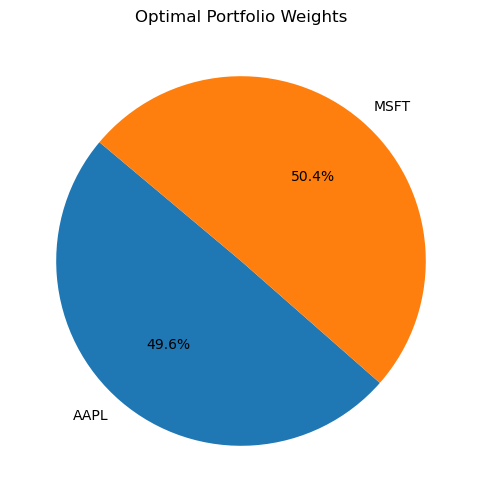

In [4]:
import matplotlib.pyplot as plt 
# Plotting the optimal weights as a pie chart

plt.figure(figsize=(8, 6))
plt.pie(optimal_weights, labels=tickers, autopct='%1.1f%%', startangle=140)
plt.title('Optimal Portfolio Weights')
plt.show() 